El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [16]:
# Cargar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

In [17]:
# Cargar el dataset
file_path = '/datasets/car_data.csv'
df = pd.read_csv(file_path)

In [18]:
# Información general del dataset
df.info()
# Visualizar las primeras filas
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [19]:
df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], inplace=True)

for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    df[column].fillna(df[column].mode()[0], inplace=True)


In [20]:
df = df[(df['Power'] > 0) & (df['Power'] < 500)]
df = df[(df['Price'] > 100) & (df['Price'] < 100000)]

categorical_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']
for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column], drop_first=True)

In [21]:
# Separar las variables independientes y dependientes
X = df.drop(columns=['Price'])
y = df['Price']

print("Tipos de datos en X:")
print(X.dtypes)

# Filtrar solo columnas numéricas (esto es una precaución extra)
X = X.select_dtypes(include=[float, int])

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Tipos de datos en X:
RegistrationYear            int64
Power                       int64
Model                      object
Mileage                     int64
RegistrationMonth           int64
VehicleType_convertible     uint8
VehicleType_coupe           uint8
VehicleType_other           uint8
VehicleType_sedan           uint8
VehicleType_small           uint8
VehicleType_suv             uint8
VehicleType_wagon           uint8
Gearbox_manual              uint8
FuelType_electric           uint8
FuelType_gasoline           uint8
FuelType_hybrid             uint8
FuelType_lpg                uint8
FuelType_other              uint8
FuelType_petrol             uint8
Brand_audi                  uint8
Brand_bmw                   uint8
Brand_chevrolet             uint8
Brand_chrysler              uint8
Brand_citroen               uint8
Brand_dacia                 uint8
Brand_daewoo                uint8
Brand_daihatsu              uint8
Brand_fiat                  uint8
Brand_ford                 

In [22]:
# Mostrar la forma de los conjuntos de datos resultantes para verificar el procesamiento
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (243934, 4)
X_test shape: (60984, 4)
y_train shape: (243934,)
y_test shape: (60984,)


## Entrenamiento del modelo 

In [23]:
# Entrenar el modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_lin = lin_reg.predict(X_test)

# Calcular el RECM (Raíz del Error Cuadrático Medio)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print("RMSE de la Regresión Lineal:", rmse_lin)

RMSE de la Regresión Lineal: 3374.600450940284


In [24]:
# Entrenar el modelo de bosque aleatorio
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Calcular el RECM para el Bosque Aleatorio
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE del Bosque Aleatorio:", rmse_rf)

RMSE del Bosque Aleatorio: 2065.1422204380665


In [25]:
# Crear y entrenar el modelo LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_lgb = lgb_model.predict(X_test)

# Calcular el RECM para LightGBM
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE de LightGBM:", rmse_lgb)

RMSE de LightGBM: 2057.3159521751845


In [26]:
# Definir los hiperparámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Configurar el modelo y la búsqueda en grid
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Crear una muestra más pequeña para la búsqueda (esto es lo nuevo)
X_train_sample = X_train.sample(frac=0.2, random_state=42)  # Usa solo el 20% de los datos
y_train_sample = y_train.loc[X_train_sample.index]

grid_search_rf.fit(X_train_sample, y_train_sample)

# Obtener el mejor modelo y su RMSE
best_rf_model = grid_search_rf.best_estimator_
rmse_rf_best = np.sqrt(-grid_search_rf.best_score_)
print("Mejor RMSE del Bosque Aleatorio en muestra:", rmse_rf_best)
print("Mejores hiperparámetros del Bosque Aleatorio en muestra:", grid_search_rf.best_params_)

Mejor RMSE del Bosque Aleatorio en muestra: 2133.963910383364
Mejores hiperparámetros del Bosque Aleatorio en muestra: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Definir los hiperparámetros a probar
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, -1],  
    'learning_rate': [0.1, 0.05],
    'num_leaves': [31, 50]
}

# Configurar el modelo y la búsqueda en grid
lgb_model = lgb.LGBMRegressor(random_state=42)
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Crear una muestra más pequeña para la búsqueda (20% de los datos)
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

grid_search_lgb.fit(X_train_sample, y_train_sample)

# Obtener el mejor modelo y su RMSE
best_lgb_model = grid_search_lgb.best_estimator_
rmse_lgb_best = np.sqrt(-grid_search_lgb.best_score_)
print("Mejor RMSE de LightGBM en muestra:", rmse_lgb_best)
print("Mejores hiperparámetros de LightGBM en muestra:", grid_search_lgb.best_params_)

In [28]:
# Evaluar el mejor modelo de Bosque Aleatorio en el conjunto de prueba completo
y_pred_rf_best = best_rf_model.predict(X_test)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
print("RMSE del mejor modelo de Bosque Aleatorio en el conjunto de prueba:", rmse_rf_test)

# Evaluar el mejor modelo de LightGBM en el conjunto de prueba completo
y_pred_lgb_best = best_lgb_model.predict(X_test)
rmse_lgb_test = np.sqrt(mean_squared_error(y_test, y_pred_lgb_best))
print("RMSE del mejor modelo de LightGBM en el conjunto de prueba:", rmse_lgb_test)

RMSE del mejor modelo de Bosque Aleatorio en el conjunto de prueba: 2103.9792672952067
RMSE del mejor modelo de LightGBM en el conjunto de prueba: 2065.996691861154


## Análisis del modelo

In [29]:
print("Resumen de RMSE de los Modelos en el Conjunto de Prueba Completo:")
print(f"RMSE del modelo de Regresión Lineal: {rmse_lin:.2f}")
print(f"RMSE del mejor modelo de Bosque Aleatorio: {rmse_rf_test:.2f}")
print(f"RMSE del mejor modelo de LightGBM: {rmse_lgb_test:.2f}")

Resumen de RMSE de los Modelos en el Conjunto de Prueba Completo:
RMSE del modelo de Regresión Lineal: 3374.60
RMSE del mejor modelo de Bosque Aleatorio: 2103.98
RMSE del mejor modelo de LightGBM: 2066.00


**Conclusión y Recomendación**

Después de evaluar diferentes modelos, los resultados indican que los modelos de Bosque Aleatorio y LightGBM ofrecen una precisión significativamente mejor que la Regresión Lineal. La diferencia en RMSE entre el Bosque Aleatorio (2103.98) y LightGBM (2065.99) es pequeña, lo que sugiere que ambos modelos son efectivos para predecir el precio de los autos de segunda mano.

### Recomendación:
Recomendaría el uso de **LightGBM** debido a su ligera ventaja en precisión y la eficiencia en tiempo de predicción, especialmente si Rusty Bargain necesita realizar predicciones en tiempo real o en grandes volúmenes de datos. Además, LightGBM suele ser más rápido en la fase de predicción que el Bosque Aleatorio, lo cual puede ser una ventaja para aplicaciones en producción.

Si se requiere una mayor interpretabilidad de las decisiones del modelo, el **Bosque Aleatorio** también es una opción sólida, ya que los modelos basados en árboles tienden a ser más fáciles de interpretar.

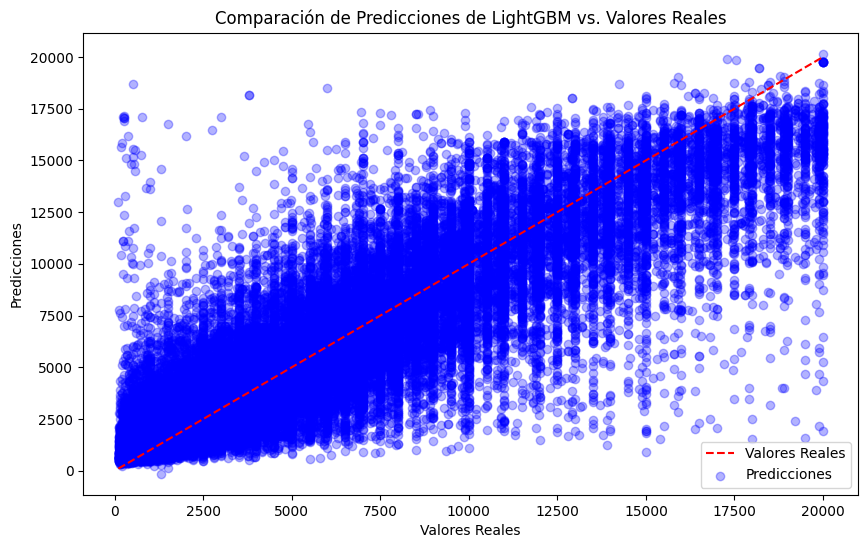

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgb_best, alpha=0.3, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones de LightGBM vs. Valores Reales')
plt.legend()
plt.show()

En el gráfico, los puntos están bastante dispersos alrededor de la línea, especialmente en los valores más altos. Esto sugiere que el modelo logra predecir con mayor precisión en el rango bajo y medio de precios, pero puede presentar mayor error para valores más altos.